Testing new visualisation features
---

---

In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()

In [2]:
os.chdir(Path(_cwd)/'..') # .\SAE\

In [3]:
import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from models import GenerativeAE
import itertools


Gradients plot (switching from plt to fig)
---

---

In [10]:
dummy_gradients1 = np.random.randn((10))
dummy_gradients2 = np.random.randn((10))
dummy_layers = [f"layer{i}" for i in range(10)]

<Figure size 432x288 with 0 Axes>

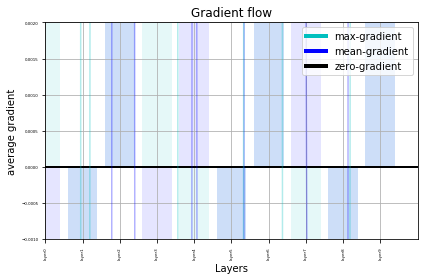

In [15]:
figure = plt.figure()
plt.bar(np.arange(len(dummy_gradients1)), dummy_gradients1, alpha=0.1, lw=1, color="c")
plt.bar(np.arange(len(dummy_gradients2)), dummy_gradients2, alpha=0.1, lw=1, color="b")
plt.plot(dummy_gradients2, alpha=0.3, color="b")
plt.plot(dummy_gradients1, alpha=0.3, color="c")
plt.hlines(0, 0, len(dummy_gradients2)+1, lw=2, color="k" )
plt.xticks(range(0,len(dummy_gradients2), 1), dummy_layers, rotation="vertical")
plt.tick_params(axis='both', labelsize=4)
plt.xlim(left=0, right=len(dummy_gradients2))
plt.ylim(bottom = -0.001, top=0.002) # zoom in on the lower gradient regions
plt.xlabel("Layers")
plt.ylabel("average gradient")
plt.title("Gradient flow")
plt.grid(True)
plt.tight_layout()
plt.legend([Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [16]:
from IPython.display import Image
Image(figure)

FileNotFoundError: No such file or directory: 'Figure(432x288)'

FileNotFoundError: No such file or directory: 'Figure(432x288)'

<IPython.core.display.Image object>